In [3]:
import os
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
from sklearn.metrics import jaccard_score
from typing import List
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), ".."))
from models.dataset import PascalPartDataset
from models.model import UNet
from utils.transforms import Compose, Resize, Normalize, RandomHorizontalFlip

# Параметры

In [4]:
batch_size: int = 4
learning_rate: float = 1e-3
num_epochs: int = 3
num_workers: int = 2
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Преобразования

In [5]:
transform: Compose = Compose(
    [
        Resize((256, 256)),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        RandomHorizontalFlip(),
    ]
)

# Датасет

In [6]:
train_dataset: PascalPartDataset = PascalPartDataset(
    images_path="../data/JPEGImages",
    masks_path="../data/gt_masks",
    transform=transform,
    mode="train",
)
val_dataset: PascalPartDataset = PascalPartDataset(
    images_path="../data/JPEGImages",
    masks_path="../data/gt_masks",
    transform=transform,
    mode="val",
)

# DataLoader

In [7]:
train_loader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
val_loader: DataLoader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

# Модель

In [8]:
model: UNet = UNet(n_classes=7).to(device)

# Функция потерь

In [9]:
criterion: nn.CrossEntropyLoss = nn.CrossEntropyLoss()

# Оптимизатор

In [11]:
optimizer: optim.Adam = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение

In [50]:
for epoch in range(num_epochs):
    model.train()
    train_loss: float = 0.0
    for i, (images, masks) in enumerate(tqdm(train_loader)):
        images = images.to(device).float().permute(0, 3, 1, 2)
        masks = masks.long().to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

100%|███████████████████████████████████████| 707/707 [1:40:37<00:00,  8.54s/it]


Epoch: 1/3, Train Loss: 0.8389


100%|███████████████████████████████████████| 707/707 [7:08:47<00:00, 36.39s/it]


Epoch: 2/3, Train Loss: 0.7254


100%|███████████████████████████████████████| 707/707 [1:53:15<00:00,  9.61s/it]

Epoch: 3/3, Train Loss: 0.7004


# Оценка

In [51]:
    model.eval()
    val_loss: float = 0.0
    iou_scores: List[float]  = []
    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(train_loader)):
            images = images.to(device).float().permute(0, 3, 1, 2)
            masks = masks.long().to(device)
    
            outputs = model(images)
            loss = criterion(outputs, masks)
    
            val_loss += loss.item()
    
            _, predictions = torch.max(outputs, 1)
            
            masks = masks.squeeze(1)  # Убираем измерение канала
            predictions = predictions.squeeze(1)  # Убираем измерение канала
            
            batch_size = min(masks.size(0), predictions.size(0))  # Учитываем минимальный размер батча
            
            iou_scores.append(jaccard_score(masks.cpu().numpy().flatten(), predictions.cpu().numpy().flatten(), average='macro'))
    
    val_loss /= len(val_loader)
    iou_score = np.mean(iou_scores)
    print(f"Epoch: {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, IoU Score: {iou_score:.4f}")



100%|█████████████████████████████████████████| 707/707 [37:46<00:00,  3.21s/it]

Epoch: 3/3, Val Loss: 2.6795, IoU Score: 0.1664


# Вычисление метрик mIoU на валидационном наборе данных:

In [57]:
model.eval()
val_loss: float = 0.0
with torch.no_grad():
    for i, (images, masks) in enumerate(tqdm(val_loader)):
        images = images.to(device).float().permute(0, 3, 1, 2)
        masks = masks.long().to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        val_loss += loss.item()

        _, predictions = torch.max(outputs, 1)

    miou0: float = jaccard_score(
        masks[:, :, 1].cpu().numpy().flatten(),
        predictions[:, :, 1].cpu().numpy().flatten(),
        average=None,
    )
    miou1: float = (
        jaccard_score(
            masks[:, :, 2].cpu().numpy().flatten(),
            predictions[:, :, 2].cpu().numpy().flatten(),
            average=None,
        )
        + jaccard_score(
            masks[:, :, 3].cpu().numpy().flatten(),
            predictions[:, :, 3].cpu().numpy().flatten(),
            average=None,
        )
    ) / 2
    miou2: float = jaccard_score(
        masks.cpu().numpy().flatten(),
        predictions.cpu().numpy().flatten(),
        average="weighted",
        zero_division=1,
    )


val_loss /= len(val_loader)
miou0_value: np.ndarray = np.round(miou0, 4)
miou1_value: float = np.round(miou1, 4)
miou2_value: float = np.round(miou2, 4)

print(f"mIoU^0: {miou0_value}")
print(f"mIoU^1: {miou1_value}")
print(f"mIoU^2: {miou2_value}")

100%|█████████████████████████████████████████| 177/177 [08:04<00:00,  2.74s/it]

mIoU^0: [0.7005 0.     0.     0.    ]
mIoU^1: [0.696 0.    0.    0.   ]
mIoU^2: 0.5035


# Сохранение модели

In [52]:
torch.save(model.state_dict(), "../models/unet_model.pth")

# Результат

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


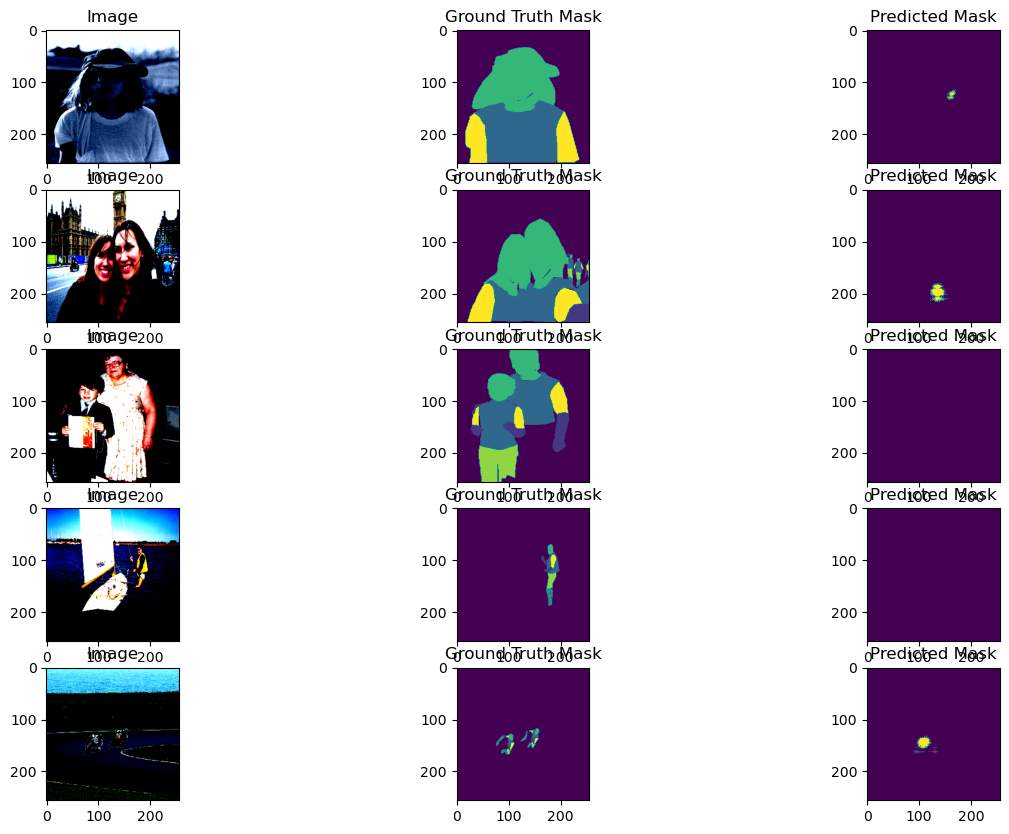

In [10]:
from typing import Tuple
import torch
import numpy as np
import matplotlib.pyplot as plt


def visualize_segmentation_results(
    model: torch.nn.Module, val_dataset: torch.utils.data.Dataset, device: torch.device
) -> None:
    model_path: str = "../models/unet_model.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))

    with torch.no_grad():
        visualize_indices = np.random.choice(len(val_dataset), size=5, replace=False)

        fig, axs = plt.subplots(nrows=len(visualize_indices), ncols=3, figsize=(15, 10))

        for i, idx in enumerate(visualize_indices):
            image, mask = val_dataset[idx]

            image: torch.Tensor = (
                torch.from_numpy(image.transpose(2, 0, 1))
                .float()
                .unsqueeze(0)
                .to(device)
            )

            output: torch.Tensor = model(image)
            _, predicted_mask = torch.max(output, 1)

            predicted_mask: np.ndarray = predicted_mask.squeeze().cpu().numpy()

            axs[i, 0].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))
            axs[i, 0].set_title("Image")
            axs[i, 1].imshow(mask)
            axs[i, 1].set_title("Ground Truth Mask")
            axs[i, 2].imshow(predicted_mask)
            axs[i, 2].set_title("Predicted Mask")

        plt.show()


visualize_segmentation_results(model, val_dataset, device)